# DevUp: Divvy Bikes - Part 1
### By Mackenzie Bogiages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import json
from math import isnan
from six.moves import urllib
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import datetime as dt
# import plotly.plotly as py
# import plotly.offline as pyo
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# from plotly.graph_objs import *
# from plotly.tools import FigureFactory as FF

In [2]:
# import data and concatenate ride dataframes
df_q1_2017 = pd.read_csv("Divvy_Trips_2017_Q1.csv")
df_q2_2017 = pd.read_csv("Divvy_Trips_2017_Q2.csv")
df_q3_2017 = pd.read_csv("Divvy_Trips_2017_Q3.csv")
df_q4_2017 = pd.read_csv("Divvy_Trips_2017_Q4.csv")
df_station_q1q2 = pd.read_csv("Divvy_Stations_2017_Q1Q2.csv")
df_station_q3q4 = pd.read_csv("Divvy_Stations_2017_Q3Q4.csv")

df_2017 = pd.concat([df_q1_2017,df_q2_2017,df_q3_2017,df_q4_2017])
df_2017.head()
df_2017.shape

(3829014, 12)

In [3]:
# concatenate to and from station names
df_station = pd.concat([df_station_q1q2, df_station_q3q4])
df_station = df_station.drop_duplicates()
df_from_station = pd.concat([df_station_q1q2,df_station_q3q4])
df_to_station = pd.concat([df_station_q1q2,df_station_q3q4])
# rename columns
df_from_station = df_from_station.rename(columns={"id": "from_station_id", "latitude": "from_lat", "longitude": "from_long"})
df_to_station = df_to_station.rename(columns={"id": "to_station_id", "latitude": "to_lat", "longitude": "to_long"})
# drop unused columns
df_from_station = df_from_station.drop(['Unnamed: 7', 'city', 'dpcapacity', 'name', 'online_date'], axis=1)
df_to_station = df_to_station.drop(['Unnamed: 7', 'city', 'dpcapacity', 'name', 'online_date'], axis=1)
# drop duplicates
df_from_station = df_from_station.drop_duplicates(subset='from_station_id', keep="last")
df_to_station = df_to_station.drop_duplicates(subset='to_station_id', keep="last")
df_to_station.shape

/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/Users/Mackenzie.Bogiages@ibm.com/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.



(585, 3)

In [4]:
# drop duplicates
df_2017 = df_2017.drop_duplicates()
# merge with from coordinates
df_2017 = df_2017.merge(df_from_station)
# merge with to coordinates
df_2017 = df_2017.merge(df_to_station)
df_2017.head()
df_2017.shape

(3829003, 16)

In [5]:
df_2017.shape

(3829003, 16)

In [6]:
# calculate distance from Haversine formula
def haversine_np(from_long, from_lat, to_long, to_lat):
    from_long, from_lat, to_long, to_lat = map(np.radians, [from_long, from_lat, to_long, to_lat])
    dlon = to_long - from_long
    dlat = to_lat - from_lat
    a = np.sin(dlat/2.0)**2 + np.cos(from_lat) * np.cos(to_lat) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3956 * c
    return r

In [7]:
# create new column for distance (miles)
df_2017['distance'] = haversine_np(df_2017['from_long'],df_2017['from_lat'],df_2017['to_long'],df_2017['to_lat'])
df_2017.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_lat,from_long,to_lat,to_long,distance
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
1,13144289,2/4/2017 00:26:16,2/4/2017 00:42:14,1716,958,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
2,13721758,4/20/2017 02:30:19,4/20/2017 02:45:13,1135,894,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
3,13695538,4/18/2017 01:32:11,4/18/2017 01:46:27,1701,856,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912
4,15718061,8/10/2017 16:40:12,8/10/2017 17:04:31,5931,1459,199,Wabash Ave & Grand Ave,171,May St & Cullerton St,Subscriber,Male,1986.0,41.891466,-87.626761,41.855136,-87.654127,2.876051


In [8]:
# calculated speed
def avg_speed_np(distance, tripduration):
    dur_hours = tripduration / (60**2)
    s = distance / dur_hours
    return s

In [9]:
# create new column for speed (MPH)
df_2017['speed'] = avg_speed_np(df_2017['distance'],df_2017['tripduration'])
df_2017.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_lat,from_long,to_lat,to_long,distance,speed
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,9.236970
1,13144289,2/4/2017 00:26:16,2/4/2017 00:42:14,1716,958,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,8.263135
2,13721758,4/20/2017 02:30:19,4/20/2017 02:45:13,1135,894,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,8.854679
3,13695538,4/18/2017 01:32:11,4/18/2017 01:46:27,1701,856,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,41.885637,-87.641823,41.855136,-87.654127,2.198912,9.247761
4,15718061,8/10/2017 16:40:12,8/10/2017 17:04:31,5931,1459,199,Wabash Ave & Grand Ave,171,May St & Cullerton St,Subscriber,Male,1986.0,41.891466,-87.626761,41.855136,-87.654127,2.876051,7.096492


In [10]:
# df_2017['start_time'] = to_datetime(df_2017['start_time'])
# df_2017['end_time'] = to_datetime(df_2017['end_time'])
df_2017['from_station_name'] = df_2017['from_station_name'].astype('category')
df_2017['to_station_name'] = df_2017['to_station_name'].astype('category')
df_2017['usertype'] = df_2017['usertype'].astype('category')
df_2017['gender'] = df_2017['gender'].astype('category')
round(df_2017.describe(),2)

,trip_id,bikeid,tripduration,from_station_id,to_station_id,birthyear,from_lat,from_long,to_lat,to_long,distance,speed
count,3829003.00,3829003.00,3829003.00,3829003.00,3829003.00,2992256.00,3829003.00,3829003.00,3829003.00,3829003.00,3829003.00,3829003.00
mean,15272182.28,3425.11,955.63,180.35,180.52,1981.59,41.90,-87.64,41.90,-87.64,1.23,5.74
std,1302949.16,1861.24,1569.45,132.82,132.93,10.88,0.04,0.02,0.04,0.02,0.95,2.39
min,12979230.00,1.00,60.00,2.00,2.00,1899.00,41.74,-87.80,41.74,-87.80,0.00,0.00
25%,14160070.00,1803.00,402.00,74.00,74.00,1976.00,41.88,-87.65,41.88,-87.65,0.57,4.40
50%,15274867.00,3583.00,686.00,156.00,156.00,1985.00,41.89,-87.64,41.89,-87.64,0.95,5.97
75%,16396155.00,5063.00,1149.00,268.00,268.00,1990.00,41.92,-87.63,41.92,-87.63,1.62,7.36
max,17536701.00,6471.00,86338.00,626.00,626.00,2017.00,42.06,-87.55,42.06,-87.55,16.96,112.50


In [11]:
df_2017.shape

(3829003, 18)

## Data Visualizations

In [12]:
# get info
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3829003 entries, 0 to 3829002
Data columns (total 18 columns):
trip_id              int64
start_time           object
end_time             object
bikeid               int64
tripduration         int64
from_station_id      int64
from_station_name    category
to_station_id        int64
to_station_name      category
usertype             category
gender               category
birthyear            float64
from_lat             float64
from_long            float64
to_lat               float64
to_long              float64
distance             float64
speed                float64
dtypes: category(4), float64(7), int64(5), object(2)
memory usage: 460.2+ MB


In [13]:
# check shape
df_2017.shape

(3829003, 18)

### Data Exploration

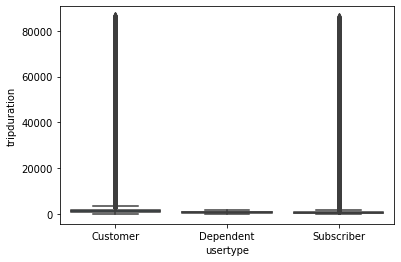

In [14]:
# check trip duration for skew
ax = sns.boxplot(x = "usertype", y = "tripduration", data = df_2017)

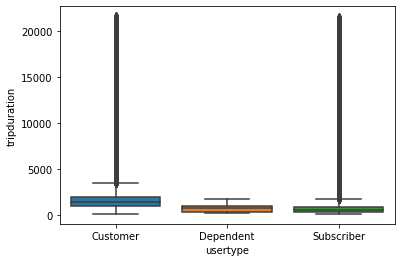

In [15]:
# drop rides less than 2 minute and greater than 6 hours
df_2017 = df_2017[df_2017.tripduration > 120]
df_2017 = df_2017[df_2017.tripduration < 21600]
ax2 = sns.boxplot(x = "usertype", y = "tripduration", data = df_2017)

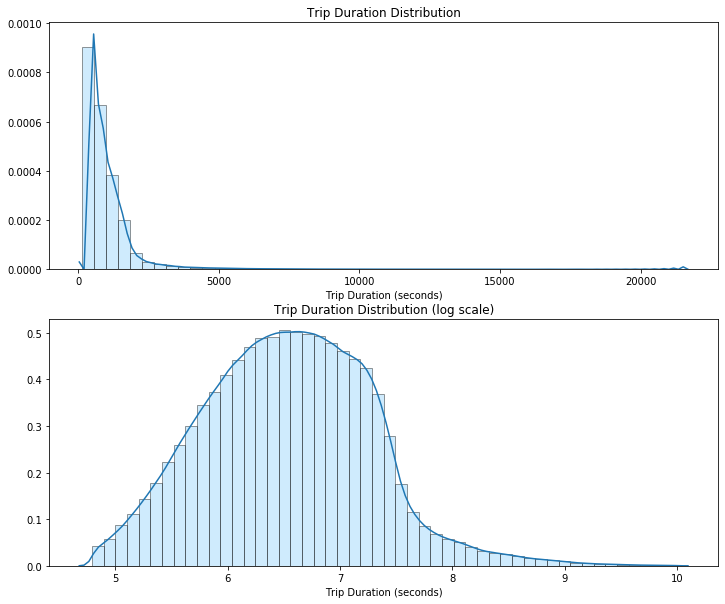

In [16]:
# trip duration distribution
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 10))
sns.distplot(df_2017['tripduration'], ax = ax[0], 
             hist_kws = {'histtype': 'bar', 'color': 'lightskyblue','edgecolor':'black'})
ax[0].set_xlabel('Trip Duration (seconds)')
ax[0].set_title('Trip Duration Distribution')

sns.distplot(np.log(df_2017['tripduration']), ax = ax[1], 
             hist_kws = {'histtype': 'bar', 'color': 'lightskyblue','edgecolor':'black'})
ax[1].set_xlabel('Trip Duration (seconds)')
ax[1].set_title('Trip Duration Distribution (log scale)')
plt.show()

In [17]:
# start count for each user type
user_type_count = df_2017.groupby('usertype').from_station_name.count()
user_type_count

usertype
Customer       831495
Dependent           7
Subscriber    2964186
Name: from_station_name, dtype: int64

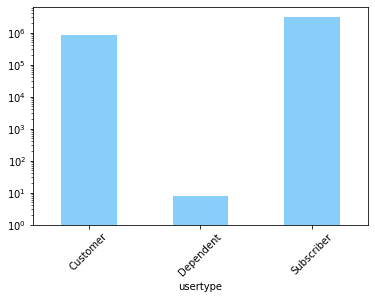

In [18]:
user_type_count.plot.bar(x = 'User Type', y = '# of Starts', log = True, rot = 45, color = 'lightskyblue')

birthyear
1899.0     521.463415
1900.0     848.735955
1901.0     618.350000
1906.0    1089.180723
1909.0    1039.800000
             ...     
2002.0     650.137931
2003.0     814.456044
2004.0     582.200000
2016.0    2456.413043
2017.0    1134.714286
Name: tripduration, Length: 87, dtype: float64

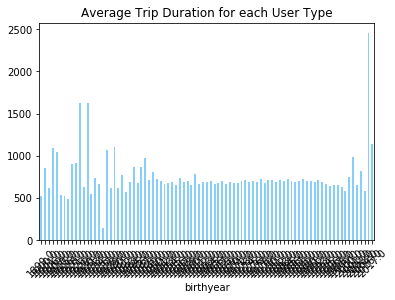

In [19]:
# trip duration by age
dur_by_age = df_2017.groupby('birthyear')["tripduration"].mean()
plot_dur_age = dur_by_age.plot.bar(x = 'Birth Year', y = 'Trip Duration (Seconds)', title = 'Average Trip Duration for each User Type', rot=45, color = "lightskyblue")
plot_dur_age
dur_by_age

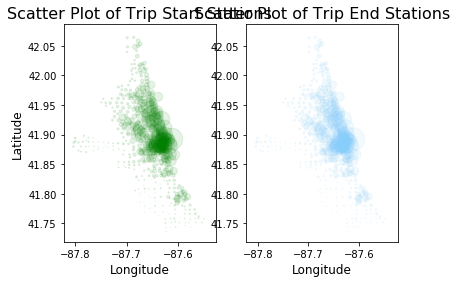

In [20]:
# plot station coordinates
# group station coordinates
from_station = df_2017[['from_long', 'from_lat', 'tripduration']]
from_station = from_station.groupby(['from_long', 'from_lat'])
from_station = from_station.count().reset_index()

to_station = df_2017[['to_long', 'to_lat', 'tripduration']]
to_station = to_station.groupby(['to_long', 'to_lat'])
to_station = to_station.count().reset_index()

# graphs
fig, ax = plt.subplots(nrows=1, ncols=2)
x = from_station['from_long']
y = from_station['from_lat']
s = from_station['tripduration'] / 200
ax[0].scatter(x, y, s=s, alpha=0.1, color='green')
ax[0].set_title('Scatter Plot of Trip Start Stations', fontsize=16)
ax[0].set_xlabel('Longitude', fontsize=12)
ax[0].set_ylabel('Latitude', fontsize=12)

x = to_station['to_long']
y = to_station['to_lat']
s = to_station['tripduration'] / 200
ax[1].scatter(x, y, s=s, alpha=0.1, color='lightskyblue')
ax[1].set_title('Scatter Plot of Trip End Stations', fontsize=16)
ax[1].set_xlabel('Longitude', fontsize=12)

plt.show()

### 1) Top 5 stations with the most starts

In [21]:
# Group start stations together
station = df_2017.groupby('from_station_name').from_station_name.count()
# Find 5 stations with most starts
top_5 = station.nlargest(n=5)
top_5

from_station_name
Streeter Dr & Grand Ave         97070
Lake Shore Dr & Monroe St       53132
Canal St & Adams St             50574
Clinton St & Washington Blvd    49542
Theater on the Lake             47627
Name: from_station_name, dtype: int64

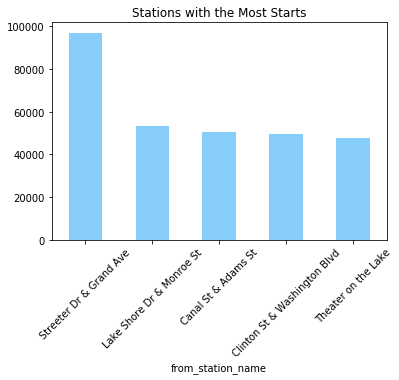

In [22]:
plot_top5 = top_5.plot.bar(x = 'Station Name', y = '# of Starts', title = 'Stations with the Most Starts', rot=45, color = "lightskyblue")
plot_top5

### 2) Trip Duration by User Type

In [23]:
# trip duration by user type
dur_by_type_total = df_2017.groupby('usertype')["tripduration"]
dur_by_type_total

In [24]:
# trip duration by user type
dur_by_type = df_2017.groupby('usertype')["tripduration"].mean()
dur_by_type/60

usertype
Customer      29.731642
Dependent     12.530952
Subscriber    11.616972
Name: tripduration, dtype: float64

In [25]:
# trip duration by user type
dur_by_type_med = df_2017.groupby('usertype')["tripduration"].median()
dur_by_type_med/60

usertype
Customer      22.850000
Dependent     13.400000
Subscriber     9.616667
Name: tripduration, dtype: float64

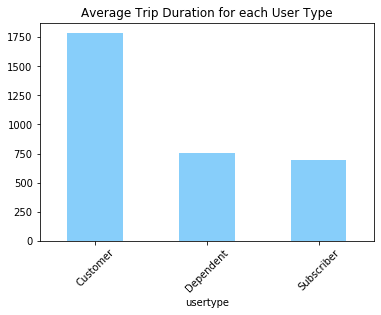

In [26]:
plot_dur = dur_by_type.plot.bar(x = 'User Type', y = 'Trip Duration (Seconds)', title = 'Average Trip Duration for each User Type', rot = 45, color = "lightskyblue")
plot_dur

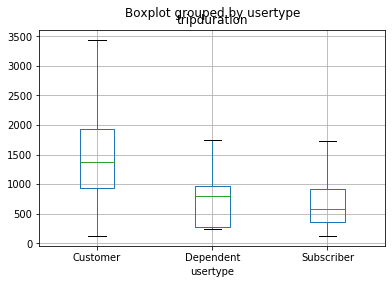

In [27]:
ax3 = df_2017.boxplot(column='tripduration', by='usertype', showfliers=False)

In [57]:
df_2017.loc[df_2017['usertype'] == 'Customer'].shape
df_2017.loc[df_2017['usertype'] == 'Customer', 'tripduration'].sum()/60/60

210.36888888888888

In [58]:
df_2017.loc[df_2017['usertype'] == 'Dependent'].shape
df_2017.loc[df_2017['usertype'] == 'Dependent', 'tripduration'].sum()/60/60

1.4619444444444445

In [59]:
df_2017.loc[df_2017['usertype'] == 'Subscriber'].shape
df_2017.loc[df_2017['usertype'] == 'Subscriber', 'tripduration'].sum()/60/60

572791.1602777778

### 3) Most Popular Trip

In [31]:
# top 10 most popular trips
pop_trip = df_2017.groupby(['from_station_name', 'to_station_name']).size().nlargest(10)
pop_trip

from_station_name           to_station_name           
Lake Shore Dr & Monroe St   Streeter Dr & Grand Ave       12170
Streeter Dr & Grand Ave     Streeter Dr & Grand Ave        9611
                            Theater on the Lake            8180
                            Lake Shore Dr & North Blvd     7992
Lake Shore Dr & North Blvd  Streeter Dr & Grand Ave        7225
Streeter Dr & Grand Ave     Lake Shore Dr & Monroe St      7190
Theater on the Lake         Streeter Dr & Grand Ave        7048
Lake Shore Dr & Monroe St   Lake Shore Dr & Monroe St      5217
Streeter Dr & Grand Ave     Michigan Ave & Oak St          4760
                            Millennium Park                4260
dtype: int64

In [32]:
# top 100 most popular trips
pop_trip100 = df_2017.groupby(['from_station_name', 'to_station_name']).size().nlargest(100)
pop_trip100

from_station_name              to_station_name               
Lake Shore Dr & Monroe St      Streeter Dr & Grand Ave           12170
Streeter Dr & Grand Ave        Streeter Dr & Grand Ave            9611
                               Theater on the Lake                8180
                               Lake Shore Dr & North Blvd         7992
Lake Shore Dr & North Blvd     Streeter Dr & Grand Ave            7225
                                                                 ...  
Canal St & Adams St            Kingsbury St & Kinzie St           1499
Clinton St & Washington Blvd   St. Clair St & Erie St             1489
Sheffield Ave & Fullerton Ave  Southport Ave & Wrightwood Ave     1474
Michigan Ave & Jackson Blvd    Indiana Ave & Roosevelt Rd         1470
Ashland Ave & Division St      Damen Ave & Division St            1455
Length: 100, dtype: int64

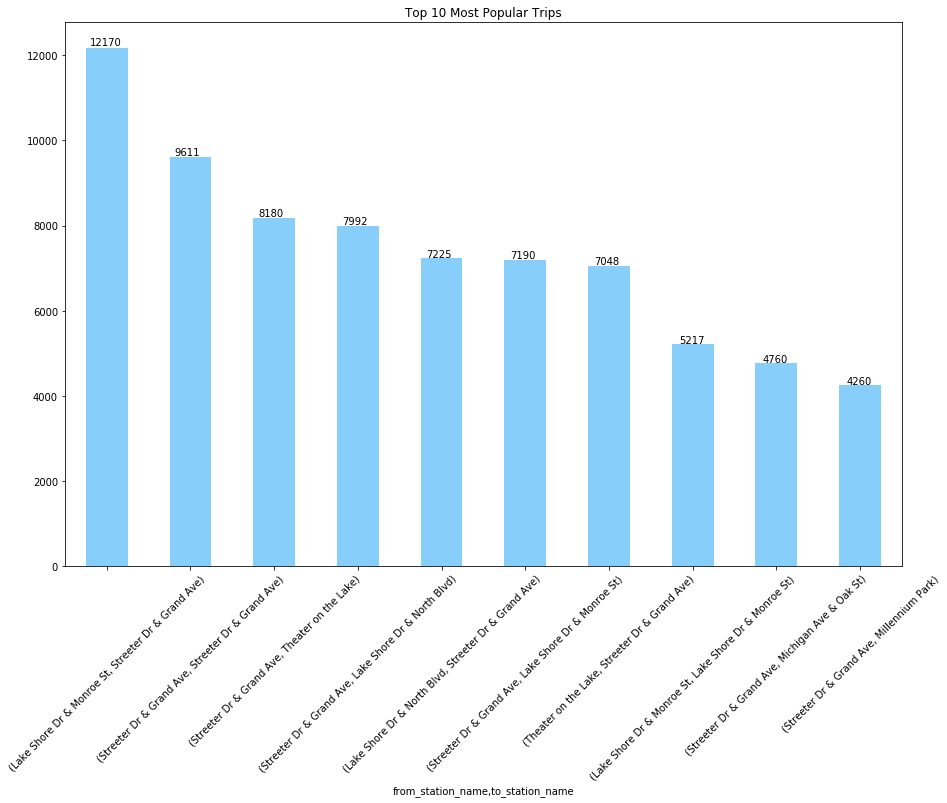

In [33]:
ax = pop_trip.head(10).plot(kind = 'bar', figsize = (15, 10), title = 'Top 10 Most Popular Trips', rot = 45, color = "lightskyblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + .05, p.get_height() * 1.005))

### 4) Rider Performance by Gender and Age

In [34]:
# drop speeds that are over 40 MPH, there are no Olympians here
df_2017 = df_2017[df_2017.speed < 40]

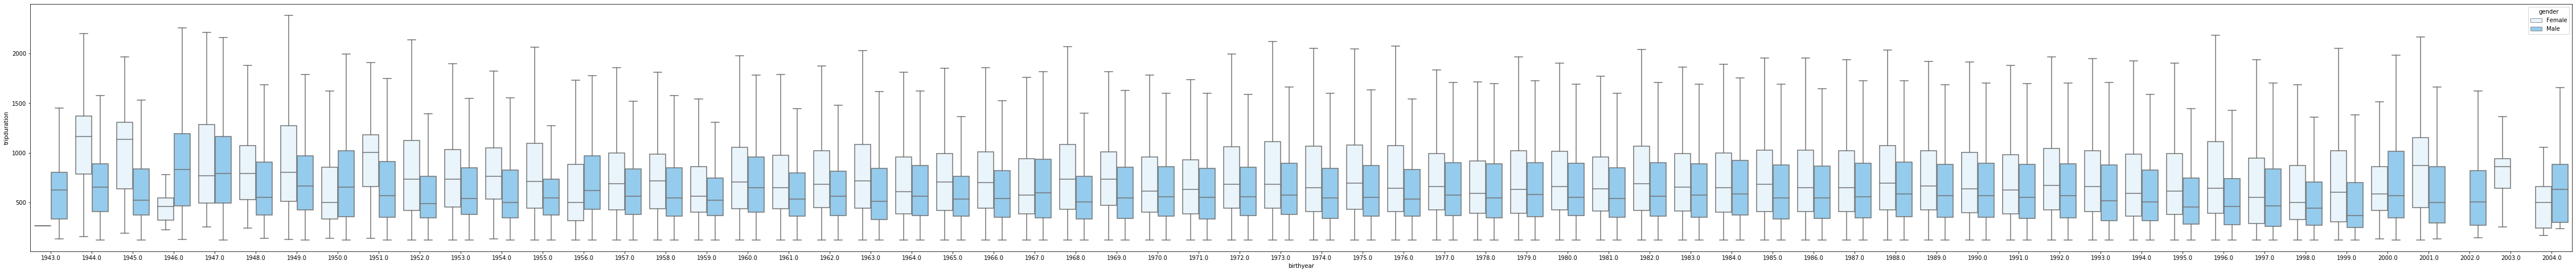

In [35]:
# drop ages that might be falsified (under 10, over 75)
df_2017 = df_2017[df_2017.birthyear > 1942]
df_2017 = df_2017[df_2017.birthyear < 2007]

# trip duration by age and gender without outliers
fig, ax4 = plt.subplots(figsize=(80,8))
ax4 = sns.boxplot(x = "birthyear", y = "tripduration", hue = "gender", data = df_2017, color = "lightskyblue", showfliers=False)

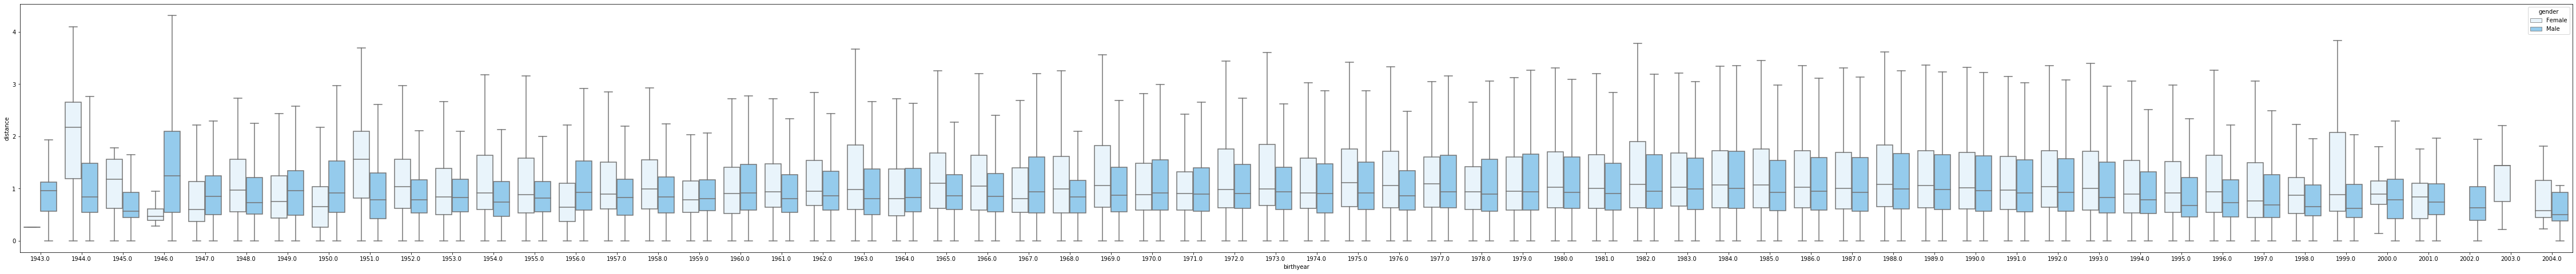

In [36]:
# trip distance by age and gender without outliers
fig, ax8 = plt.subplots(figsize=(80,8))
ax4 = sns.boxplot(x = "birthyear", y = "distance", hue = "gender", data = df_2017, color = "lightskyblue", showfliers=False)

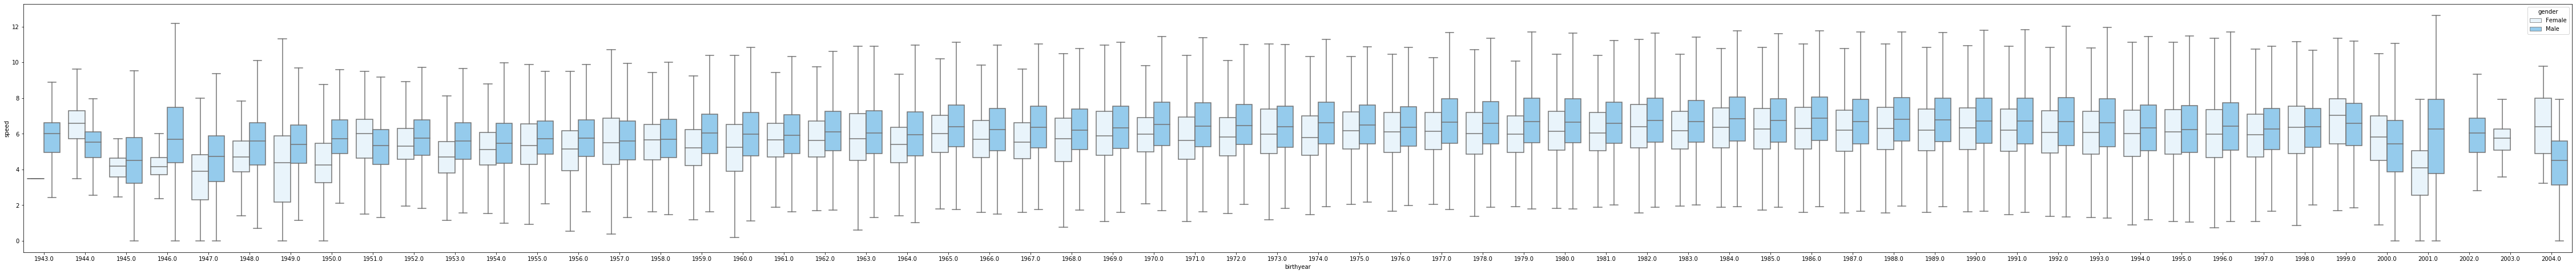

In [37]:
# trip average speed by age and gender without outliers
fig, ax9 = plt.subplots(figsize=(80,8))
ax4 = sns.boxplot(x = "birthyear", y = "speed", hue = "gender", data = df_2017, color = "lightskyblue", showfliers=False)

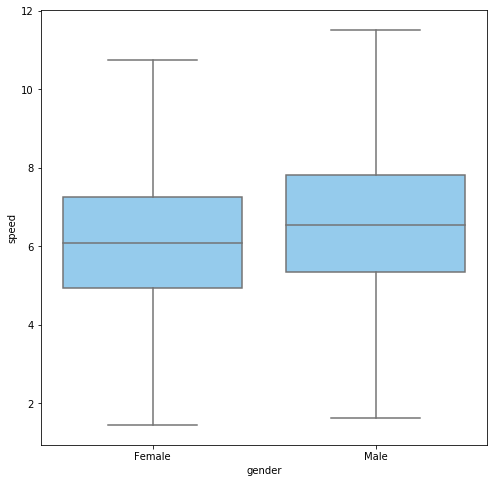

In [38]:
# trip speed by gender without outliers
fig, ax10 = plt.subplots(figsize=(8,8))
ax10 = sns.boxplot(x = "gender", y = "speed", data = df_2017, color = "lightskyblue", showfliers=False)

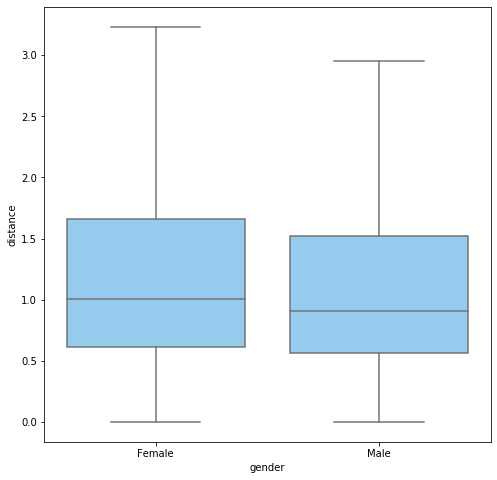

In [39]:
# trip distance by gender without outliers
fig, ax11 = plt.subplots(figsize=(8,8))
ax11 = sns.boxplot(x = "gender", y = "distance", data = df_2017, color = "lightskyblue", showfliers=False)

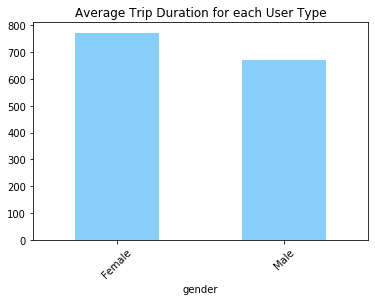

In [40]:
# trip duration by gender
dur_by_gen = df_2017.groupby('gender')["tripduration"].mean()
dur_by_gen
plot_dur_gen = dur_by_gen.plot.bar(x = 'Gender', y = 'Trip Duration (Seconds)', title = 'Average Trip Duration for each User Type', rot=45, color = "lightskyblue")
plot_dur_gen

In [41]:
# make age groups, 17 if birth year = 2000, 70 if birth year = 1947
# age groups [17-25), [25-35), [35-45), [45-55), [55-65), [65-70]
age_1 = df_2017[(df_2017.birthyear <= 2000) & (df_2017.birthyear > 1992)]
age_2 = df_2017[(df_2017.birthyear <= 1992) & (df_2017.birthyear > 1982)]
age_3 = df_2017[(df_2017.birthyear <= 1982) & (df_2017.birthyear > 1972)]
age_4 = df_2017[(df_2017.birthyear <= 1972) & (df_2017.birthyear > 1962)]
age_5 = df_2017[(df_2017.birthyear <= 1962) & (df_2017.birthyear > 1952)]
age_6 = df_2017[(df_2017.birthyear <= 1952) & (df_2017.birthyear > 1946)]

In [60]:
print(age_1.loc[age_1['gender'] == 'Male', 'speed'].median())
print(age_1.loc[age_1['gender'] == 'Male', 'distance'].mean())
print(age_1.loc[age_1['gender'] == 'Female', 'speed'].median())
print(age_1.loc[age_1['gender'] == 'Female', 'distance'].mean())

print(age_2.loc[age_2['gender'] == 'Male', 'speed'].median())
print(age_2.loc[age_2['gender'] == 'Male', 'distance'].mean())
print(age_2.loc[age_2['gender'] == 'Female', 'speed'].median())
print(age_2.loc[age_2['gender'] == 'Female', 'distance'].mean())

print(age_3.loc[age_3['gender'] == 'Male', 'speed'].median())
print(age_3.loc[age_3['gender'] == 'Male', 'distance'].mean())
print(age_3.loc[age_3['gender'] == 'Female', 'speed'].median())
print(age_3.loc[age_3['gender'] == 'Female', 'distance'].mean())

print(age_4.loc[age_4['gender'] == 'Male', 'speed'].median())
print(age_4.loc[age_4['gender'] == 'Male', 'distance'].mean())
print(age_4.loc[age_4['gender'] == 'Female', 'speed'].median())
print(age_4.loc[age_4['gender'] == 'Female', 'distance'].mean())

print(age_5.loc[age_5['gender'] == 'Male', 'speed'].median())
print(age_5.loc[age_5['gender'] == 'Male', 'distance'].mean())
print(age_5.loc[age_5['gender'] == 'Female', 'speed'].median())
print(age_5.loc[age_5['gender'] == 'Female', 'distance'].mean())

print(age_6.loc[age_6['gender'] == 'Male', 'speed'].median())
print(age_6.loc[age_6['gender'] == 'Male', 'distance'].mean())
print(age_6.loc[age_6['gender'] == 'Female', 'speed'].median())
print(age_6.loc[age_6['gender'] == 'Female', 'distance'].mean())

6.444038508766306
1.0613065740001792
6.059879175703784
1.208538807846518
6.7462270009403165
1.2254408178528335
6.237812106230306
1.2911375016813496
6.597066423510615
1.222197145865236
6.107128124068616
1.290200476298094
6.305229801400486
1.1218610054936637
5.740105705452525
1.174932117402487
5.842931560617683
1.043553869602814
5.397389092190752
1.1078452169551034
5.548243004800659
0.9742571245341005
5.095163490318795
1.1077552605173937


### 5) Busiest Bike

In [43]:
# busiest bike by number of starts
bikes = df_2017.groupby(['bikeid']).count()['trip_id'].sort_values(ascending=False)
bikes.head()

bikeid
2565    1231
3489    1043
3308     996
2438     993
5719     972
Name: trip_id, dtype: int64

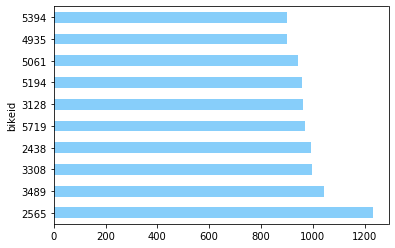

In [44]:
bikes.head(10).plot.barh(x = 'Top Bikes', y = '# of Starts', color = "lightskyblue")

In [45]:
# busiest bike by seconds used
bikes_seconds = df_2017.groupby(['bikeid']).sum()['tripduration'].sort_values(ascending=False)
bikes_seconds.head()

bikeid
2565    890718
3489    730690
2438    704021
3308    693321
5719    678344
Name: tripduration, dtype: int64

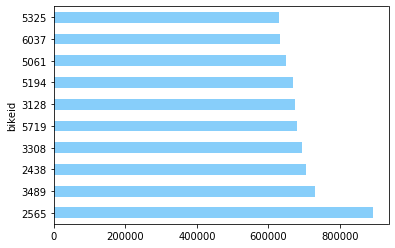

In [46]:
bikes_seconds.head(10).plot.barh(x = 'Top Bikes', y = 'Seconds Used', color = "lightskyblue")